In [1]:
# Importem Pandas
from pathlib import Path
import pandas as pd

def carrega_dades(fitxer):
    # Definim la ruta on es troba el fitxer    
    return pd.read_csv(Path("dataset/",fitxer))

In [2]:
df=carrega_dades("dades.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Data    1252 non-null   int64
 1   Total   1252 non-null   int64
dtypes: int64(2)
memory usage: 19.7 KB


In [4]:
# Convertim la columna del timestamp (int64)
# a format datetime. El paràmetre unit='s' indica
# que els nombre a convertir estan espeficicat en segons.
df['Data'] = pd.to_datetime(df['Data'], unit='s')

# I l'establim com a índex amb set_index
df=df.set_index('Data')

<Axes: xlabel='Data'>

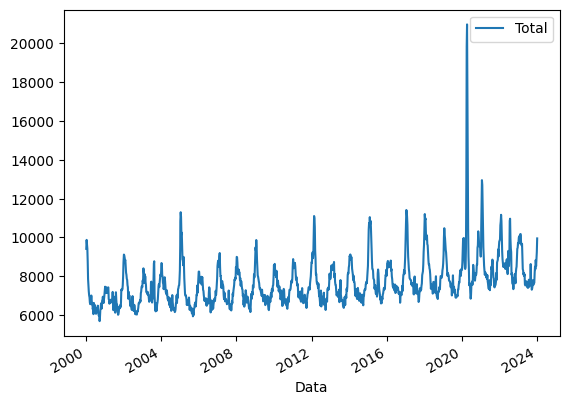

In [5]:
df.plot()

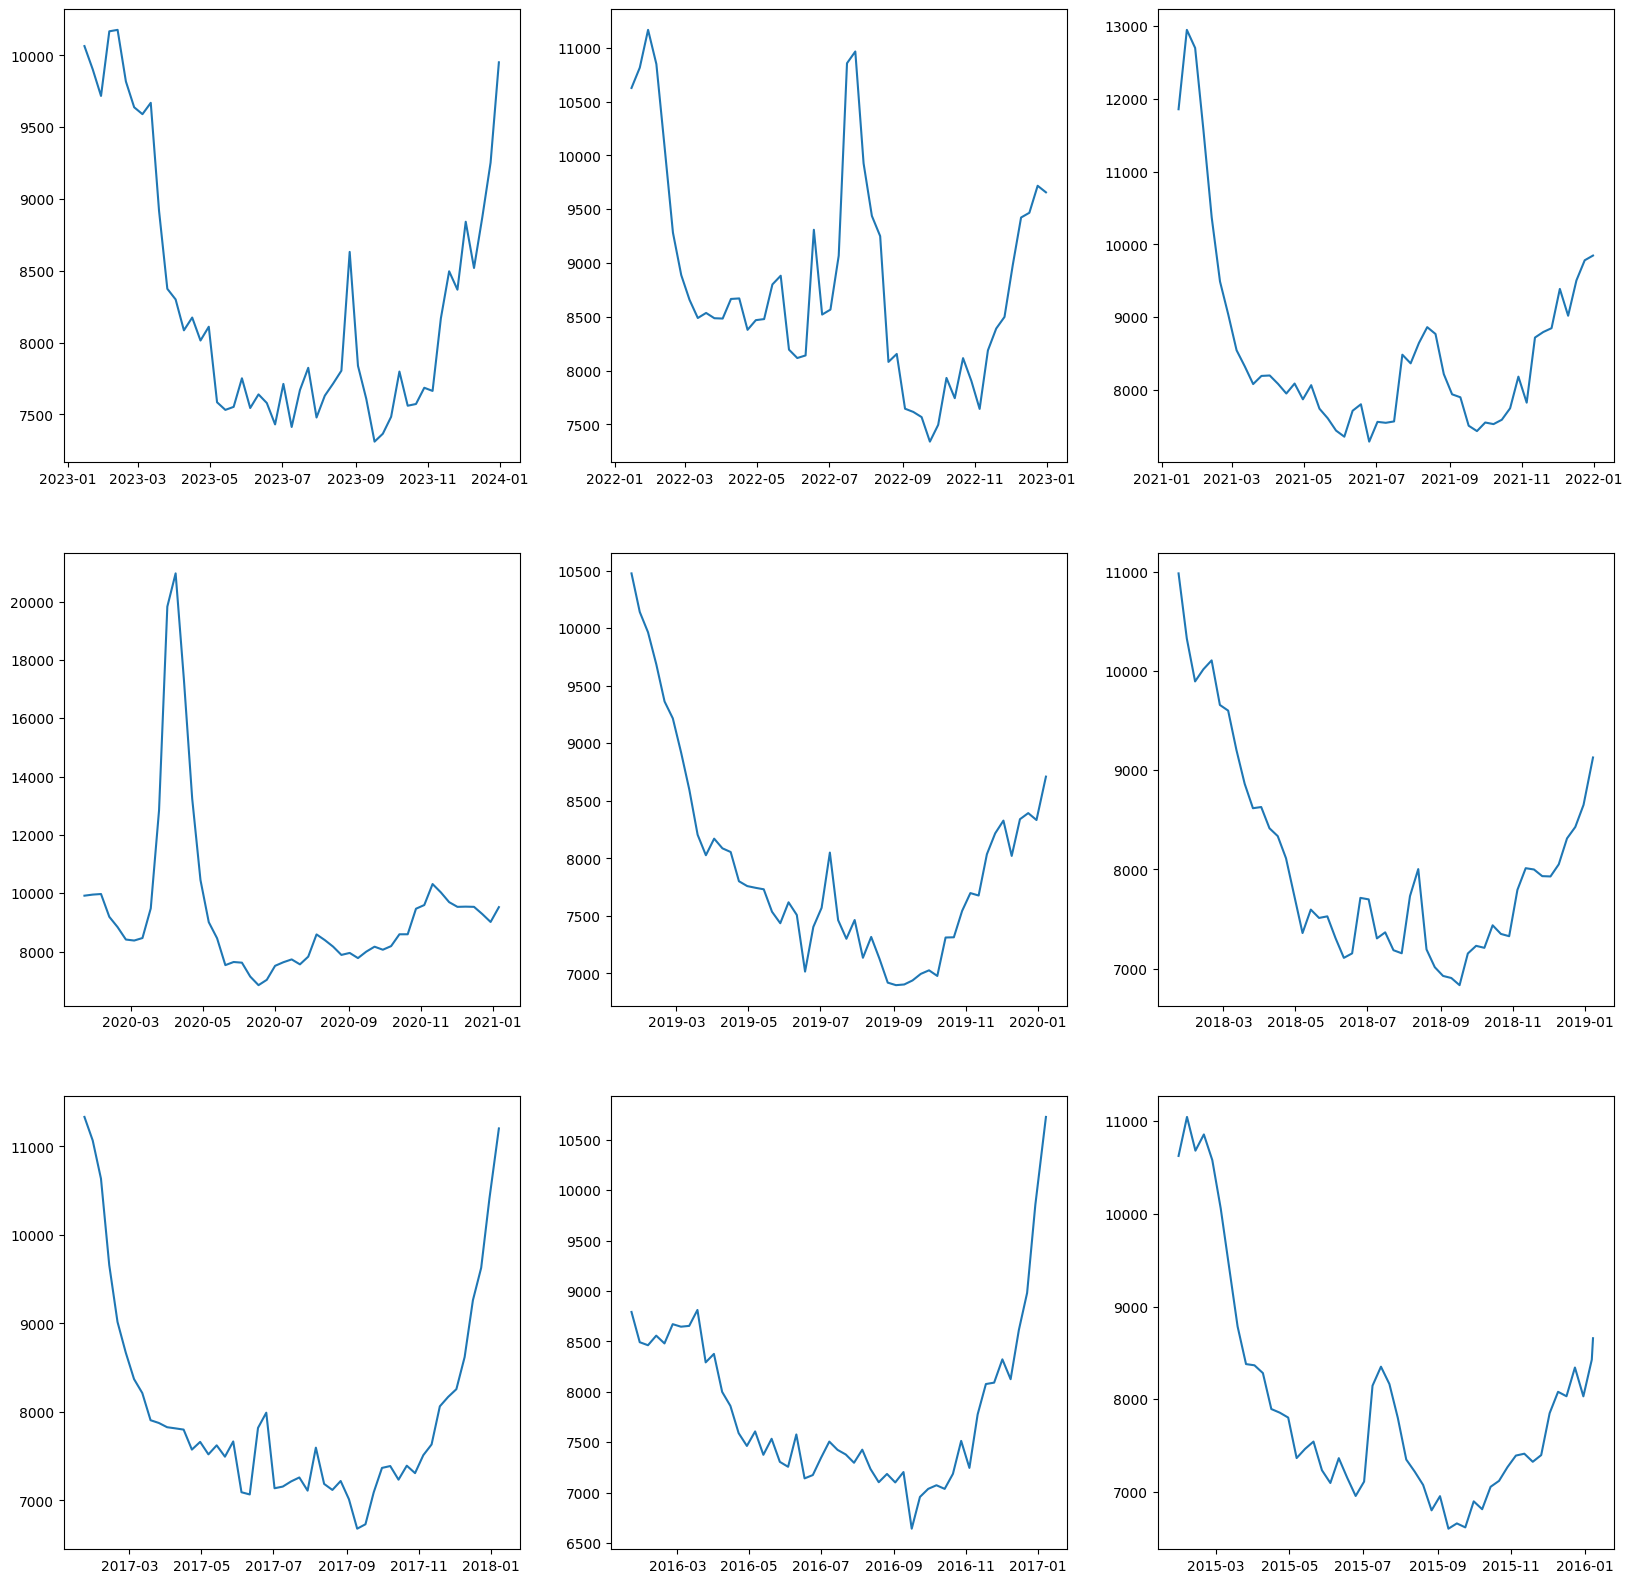

In [6]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(3, 3, figsize=(20, 20)) 

for i in range(0,9):
    fila = i // 3  # Fila del subgràfic
    columna = i % 3   # Columna del subgràfic
    axs[fila,columna].plot(df.iloc[i*52:i*52+51])
        



<Figure size 2400x1200 with 0 Axes>

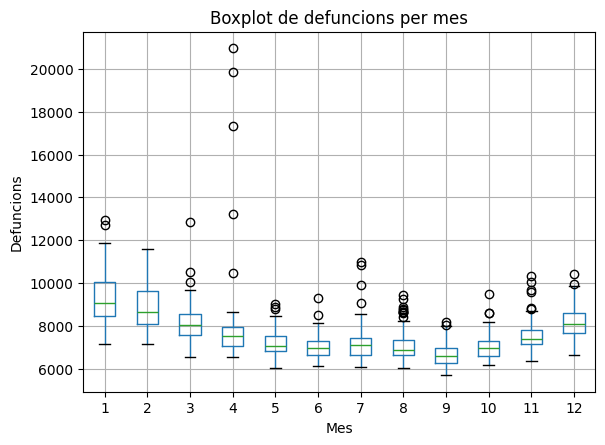

In [7]:
import matplotlib.pyplot as plt

# Creem una nova columna amb el mes de cada data
df['Mes'] = df.index.month

# Dibuixem un boxplot per a cada mes
plt.figure(figsize=(24,12))
df.boxplot(column='Total', by='Mes')
plt.title('Boxplot de defuncions per mes')
plt.suptitle('') # Això és per a eliminar el títol automàtic que afegeix pandas
plt.xlabel('Mes')
plt.ylabel('Defuncions')
plt.show()


# Comprovant l'estacionarietat amb el test de Dickey-Fulley

In [177]:
pip install statsmodels

407501.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.


In [8]:
# importem la classe adfuller de la llibreria statsmodels

from statsmodels.tsa.stattools import adfuller

# I l'apliquem a la columna de dades de la que 
# ens interessa conéixer l'estacionarietat

resultat = adfuller(df["Total"]);

# I comprovem aquesta
print('Estadística ADF: %f' % resultat[0])
print('Probabilitat (p): %f' % resultat[1])
print('valors crítics:')
for key, value in resultat[4].items():
    print('\t%s: %.3f' % (key, value))


Estadística ADF: -7.820358
Probabilitat (p): 0.000000
valors crítics:
	1%: -3.436
	5%: -2.864
	10%: -2.568


Anem a crear un senzill model, basat en regressió linial per predir els valors futurs d'aquesta sèries.

In [9]:
# Creem una còpia del Dataframe original, ja amb els índex creats
df_orig=df

In [10]:
# En primer lloc, anem a crear les variables explicatives, o lags. Per exemple amb 10 valors

for i in range(1, 11):
    df['Lag_' + str(i)] = df['Total'].shift(i)

# Eliminem els nuls
df = df.dropna()

In [11]:
# Dividim les dades en conjunt d'entrenament i de prova
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('Total', axis=1), df['Total'], test_size=0.2, random_state=42)

# Recordeu que les X seran un Dataframe de Pandas,
# mentre que les y seran una sèrie



In [12]:
# Creem i entrenem el model de regressió linial
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [13]:
# I finalment, llancem les prediccions i avaluem el model

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)


In [14]:
def mostraMetriques(y_test, y_pred):
    eam=mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse=mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print('EAM: %f' % eam)
    print('MSE: %f' % mse)
    print('RMSE: %f' % rmse)
    print('R2: %f' % r2)

In [15]:
mostraMetriques(y_test, y_pred)

EAM: 255.380600
MSE: 159636.330008
RMSE: 399.545154
R2: 0.888180


In [16]:
# Veiem la mitjana
df["Total"].mean()

7673.054750402576

Com veiem, EAM i RMSE donen uns errors d'entre 255 i 399 defuncions, per a una mitjana de 7673, que no està gens malament, tal i com conirma el valor R2 d'un 0.88.

Veiem-ho gràficament:

In [17]:
y_test.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 249 entries, 2006-07-23 to 2012-10-14
Series name: Total
Non-Null Count  Dtype
--------------  -----
249 non-null    int64
dtypes: int64(1)
memory usage: 3.9 KB


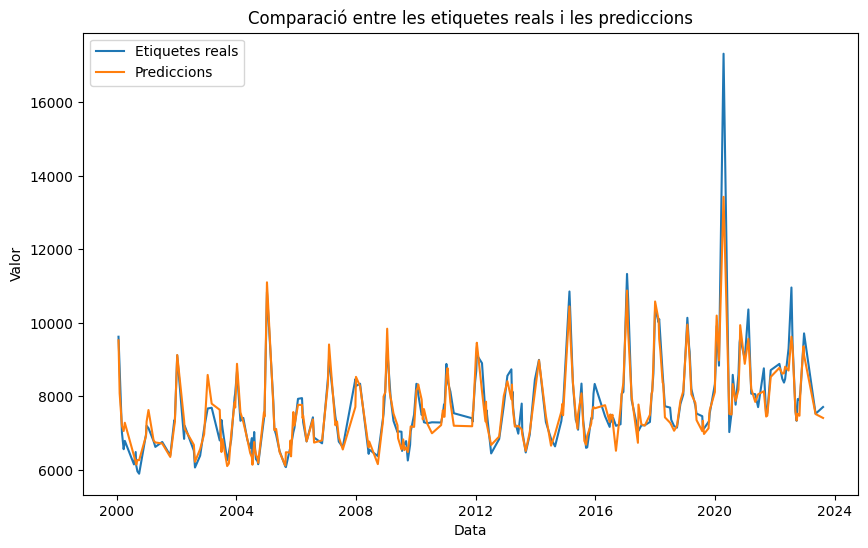

In [18]:
import matplotlib.pyplot as plt

def dibuixaSerie(y_test, y_pred):

    # Creem un dataframe amb les prediccions
    y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=['y_pred'])

    # Ordenem els índex
    y_test = y_test.sort_index()
    y_pred_df = y_pred_df.sort_index()

    # Dibuixa les dades
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Etiquetes reals')
    plt.plot(y_pred_df, label='Prediccions')
    plt.title('Comparació entre les etiquetes reals i les prediccions')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()

dibuixaSerie(y_test, y_pred)


## Utilitzant els últims registres com a test

Un altre enfocament per fer la divisió entre conjunt de prova i de test utilitzat en sèries temporals és fer ús de les dades més recents com a conjunt de prova, el que simula la situació real en què volem predir el futur basant-nos en dates més recents. 

Així, si agafem l'últim 20% de les dades com a test, suposaria agafar les últimes 250 files. Aquestes últimes dades, també es coneixen com *steps*.

In [26]:
# Dividim el dataframe, eliminant nuls

df=df_orig.dropna()

# Important! Ordenm per l'índex!
df=df.sort_index()

steps=250
# Açò agafaria els primers registres
train_set=df[:-steps]
test_set=df[-steps:]


In [27]:
# Dividim les variables de la variable objectiu

X_train=train_set.drop("Total", axis=1)
Y_train=train_set["Total"].copy()

X_test=test_set.drop("Total", axis=1)
Y_test=test_set["Total"].copy()



In [28]:
# Fem l'entrenament

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [29]:
# Llancem les prediccions per al test
y_pred = model.predict(X_test)

In [30]:
mostraMetriques(Y_test, y_pred)

EAM: 365.764877
MSE: 494526.038885
RMSE: 703.225454
R2: 0.819059


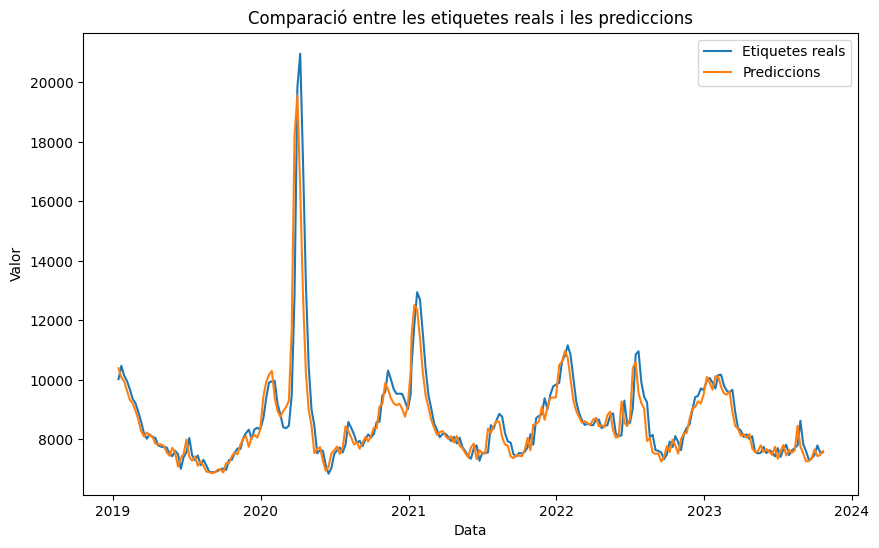

In [31]:
dibuixaSerie(Y_test, y_pred)